# Cats vs Dogs

### Loading our images 
- Images are labeled catxxx.jpg and dogxxx.jpg

In [17]:
# Get filenames in list
from os import listdir
from os.path import isfile, join

mypath = "datasets//catsvsdogs//images//"

file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]

print(str(len(file_names)) + ' images loaded')

3002 images loaded


### Splitting our loaded images into a training and test/validation dataset
- We also need to store their labels (i.e. y_train and y_test)
- We re-size our images here to maintain a constant dimension of 150 x 150
- We're going to use 1000 images of dogs and 1000 images of cats as our training data
- For our test/validation dataset we're going to use 500 of each class
- Dogs will be labels 1 and cats 0
- We store our new images in the following directories
 - /datasets/catsvsdogs/train/dogs
 - /datasets/catsvsdogs/train/cats
 - /datasets/catsvsdogs/validation/dogs
 - /datasets/catsvsdogs/validation/cats

In [18]:
import cv2
import numpy as np
import sys
import os
import shutil

# Extract 1000 for our training data and 500 for our validation set
# Takes about ~20 seconds to run
dog_count = 0
cat_count = 0
training_size = 1000
test_size = 500
training_images = []
training_labels = []
test_images = []
test_labels = []
size = 150
dog_dir_train = "./datasets/catsvsdogs/train/dogs/"
cat_dir_train = "./datasets/catsvsdogs/train/cats/"
dog_dir_val = "./datasets/catsvsdogs/validation/dogs/"
cat_dir_val = "./datasets/catsvsdogs/validation/cats/"

def make_dir(directory):
        if os.path.exists(directory):
            shutil.rmtree(directory)
        os.makedirs(directory)

make_dir(dog_dir_train)
make_dir(cat_dir_train)
make_dir(dog_dir_val)
make_dir(cat_dir_val)

def getZeros(number):
    if(number > 10 and number < 100):
        return "0"
    if(number < 10):
        return "00"
    else:
        return ""

for i, file in enumerate(file_names):
    
    if file_names[i][0] == "d":
        dog_count += 1
        image = cv2.imread(mypath+file)
        image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
        if dog_count <= training_size:
            training_images.append(image)
            training_labels.append(1)
            zeros = getZeros(dog_count)
            cv2.imwrite(dog_dir_train + "dog" + str(zeros) + str(dog_count) + ".jpg", image)
        if dog_count > training_size and dog_count <= training_size+test_size:
            test_images.append(image)
            test_labels.append(1)
            zeros = getZeros(dog_count-1000)
            cv2.imwrite(dog_dir_val + "dog" + str(zeros) + str(dog_count-1000) + ".jpg", image)
            
    if file_names[i][0] == "c":
        cat_count += 1
        image = cv2.imread(mypath+file)
        image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
        if cat_count <= training_size:
            training_images.append(image)
            training_labels.append(0)
            zeros = getZeros(cat_count)
            cv2.imwrite(cat_dir_train + "cat" + str(zeros) + str(cat_count) + ".jpg", image)
        if cat_count > training_size and cat_count <= training_size+test_size:
            test_images.append(image)
            test_labels.append(0)
            zeros = getZeros(cat_count-1000)
            cv2.imwrite(cat_dir_val + "cat" + str(zeros) + str(cat_count-1000) + ".jpg", image)

    if dog_count == training_size+test_size and cat_count == training_size+test_size:
        break

print("Training and Test Data Extraction Complete")

Training and Test Data Extraction Complete


### Let's save our dataset's to NPZ files

In [19]:
# Using numpy's savez function to store our loaded data as NPZ files
np.savez('cats_vs_dogs_training_data.npz', np.array(training_images))
np.savez('cats_vs_dogs_training_labels.npz', np.array(training_labels))
np.savez('cats_vs_dogs_test_data.npz', np.array(test_images))
np.savez('cats_vs_dogs_test_labels.npz', np.array(test_labels))

In [20]:
# Loader Function
import numpy as np

def load_data_training_and_test(datasetname):
    
    npzfile = np.load(datasetname + "_training_data.npz")
    train = npzfile['arr_0']
    
    npzfile = np.load(datasetname + "_training_labels.npz")
    train_labels = npzfile['arr_0']
    
    npzfile = np.load(datasetname + "_test_data.npz")
    test = npzfile['arr_0']
    
    npzfile = np.load(datasetname + "_test_labels.npz")
    test_labels = npzfile['arr_0']

    return (train, train_labels), (test, test_labels)

### Let's view some of our loaded images

In [21]:
for i in range(1,11):
    random = np.random.randint(0, len(training_images))
    cv2.imshow("image_"+str(i), training_images[random])
    if training_labels[random] == 0:
        print(str(i) + " - Cat")
    else:
        print(str(i)+ " - Dog")
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

1 - Dog
2 - Dog
3 - Cat
4 - Dog
5 - Dog
6 - Dog
7 - Cat
8 - Dog
9 - Cat
10 - Cat


### Let's get our data ready in the format expected by Keras
- We also stick the previous naming convention 

In [22]:
(x_train, y_train), (x_test, y_test) = load_data_training_and_test("cats_vs_dogs")

# Reshaping our label data from (2000,) to (2000,1) and test data from (1000,) to (1000,1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change our image type to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255
x_test /= 255

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2000, 150, 150, 3)
(2000, 1)
(1000, 150, 150, 3)
(1000, 1)


### Let's create our model using a simple CNN that similar to what we used for CIFAR10
- Except now we use a Sigmoid instead of Softmax
- **Sigmoids are used when we're doing binary (i.e. two class) classification
- Note the binary_crossentropy loss

In [23]:
from __future__ import print_function
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 16
epochs = 25

img_rows = x_train[0].shape[0]
img_cols = x_train[1].shape[0]
input_shape = (img_rows, img_cols, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

c:\Users\Karthick Selvam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212,513 (4.63 MB)

 Trainable params: 1,212,513 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

None


### Training our model

In [24]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

model.save("cats_vs_dogs_V1.h5")

# Evaluate the performance of our trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.4956 - loss: 0.7702 - val_accuracy: 0.5050 - val_loss: 0.6913
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5399 - loss: 0.6947 - val_accuracy: 0.6610 - val_loss: 0.6638
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5952 - loss: 0.6721 - val_accuracy: 0.6380 - val_loss: 0.6325
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.6640 - loss: 0.6340 - val_accuracy: 0.6790 - val_loss: 0.6007
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.7015 - loss: 0.5632 - val_accuracy: 0.7140 - val_loss: 0.5576
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.7400 - loss: 0.5352 - val_accuracy: 0.7270 - val_loss: 0.5461
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.7653 - loss: 0.4961 - val_accuracy: 0.6290 - val_loss: 0.7465
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.7735 - loss: 0.4705 - val_ac

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7056 - loss: 1.9461
Test loss: 1.790094256401062
Test accuracy: 0.7369999885559082


### Testing our Classifier

In [25]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
classifier = load_model('cats_vs_dogs_V1.h5')

def draw_test(name, pred, input_im):
    BLACK = [0, 0, 0]
    # Convert prediction result to a class label
    if pred == 0:
        label = "cat"
    elif pred == 1:
        label = "dog"
    
    # Add border to the image
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0], cv2.BORDER_CONSTANT, value=BLACK)
    
    # Add prediction label text to the image
    cv2.putText(expanded_image, str(label), (252, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 4, (0, 255, 0), 2)
    
    # Display the image with the prediction
    cv2.imshow(name, expanded_image)

# Test on 10 random images from the test set
for i in range(10):
    rand = np.random.randint(0, len(x_test))
    input_im = x_test[rand]

    # Resize the image for better visualization
    imageL = cv2.resize(input_im, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    cv2.imshow("Test Image", imageL)

    # Prepare the image for prediction
    input_im = input_im.reshape(1, 150, 150, 3) 
    
    # Get prediction (using predict() and argmax() to determine the class)
    res = np.argmax(classifier.predict(input_im, verbose=0), axis=1)[0]

    # Draw the result
    draw_test("Prediction", res, imageL)
    
    # Wait for a key press before showing the next image
    cv2.waitKey(0)

cv2.destroyAllWindows()


### Analysis
- Our results aren't bad, but they could be better

# Now let's train our Cats vs Dogs Classifier using Data Augmentation

In [10]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import scipy
import pylab as pl
import matplotlib.cm as cm
%matplotlib inline

input_shape = (150, 150, 3)
img_width = 150
img_height = 150

nb_train_samples = 2000
nb_validation_samples = 1000
batch_size = 16
epochs = 25

train_data_dir = './datasets/catsvsdogs/train'
validation_data_dir = './datasets/catsvsdogs/validation'

# Creating our data generator for our test data
validation_datagen = ImageDataGenerator(
    # used to rescale the pixel values from [0, 255] to [0, 1] interval
    rescale = 1./255)

# Creating our data generator for our training data
train_datagen = ImageDataGenerator(
      rescale = 1./255,              # normalize pixel values to [0,1]
      rotation_range = 30,           # randomly applies rotations
      width_shift_range = 0.3,       # randomly applies width shifting
      height_shift_range = 0.3,      # randomly applies height shifting
      horizontal_flip = True,        # randonly flips the image
      fill_mode = 'nearest')         # uses the fill mode nearest to fill gaps created by the above

# Specify criteria about our training data, such as the directory, image size, batch size and type 
# automagically retrieve images and their classes for train and validation sets
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = False)    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Create our model, just like we did previously

In [11]:
# Creating out model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

c:\Users\Karthick Selvam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212,513 (4.63 MB)

 Trainable params: 1,212,513 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/25


c:\Users\Karthick Selvam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 220ms/step - accuracy: 0.4888 - loss: 0.7905 - val_accuracy: 0.5605 - val_loss: 0.6918
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.6989
Epoch 3/25


c:\Users\Karthick Selvam\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.5170 - loss: 0.6959 - val_accuracy: 0.4970 - val_loss: 0.6944
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5835
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.5464 - loss: 0.6894 - val_accuracy: 0.6230 - val_loss: 0.6803
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 0.7077
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.5581 - loss: 0.6810 - val_accuracy: 0.5413 - val_loss: 0.6726
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4898
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.5748 - loss: 0.6712 - val_accuracy: 0.6552 - val_loss: 0.6465
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step - accuracy: 0.0000e+00

## Plotting our Loss and Accuracy Graphs

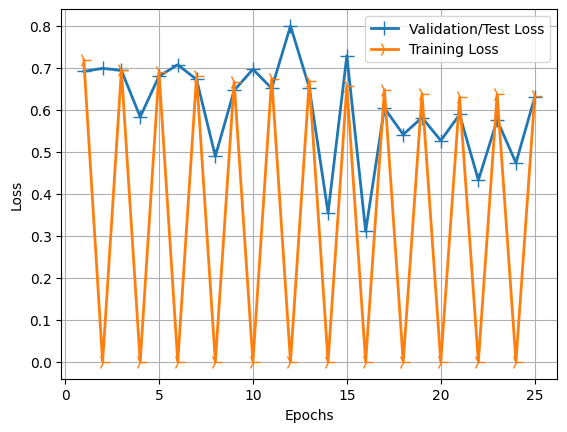

In [14]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

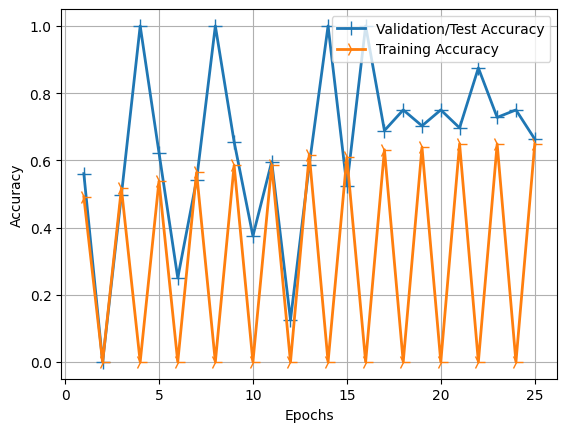

In [16]:
import matplotlib.pyplot as plt

# Get the history data from the training process
history_dict = history.history

# Extract accuracy and validation accuracy values
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

# Extract loss values (make sure you defined loss_values in your code)
epochs = range(1, len(acc_values) + 1)

# Plot the accuracy values for training and validation
plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy', linewidth=2.0, marker='+', markersize=10.0)
plt.plot(epochs, acc_values, label='Training Accuracy', linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()